# PubmedBert Embedding 

In [1]:
import os
from pathlib import Path
import sys
node_type = os.getenv('BB_CPU')
venv_dir = f'/rds/homes/t/talayag/talayag-agt-computations/opl_analysis/opl-venv-{node_type}'  # edit this line to match the venv directory format
venv_site_pkgs = Path(venv_dir) / 'lib' / f'python{sys.version_info.major}.{sys.version_info.minor}' / 'site-packages'
if venv_site_pkgs.exists():
    sys.path.insert(0, str(venv_site_pkgs))
else:
    print(f"Path '{venv_site_pkgs}' not found. Check that it exists and/or that it exists for node-type '{node_type}'.")

In [30]:
import pandas as pd 

import transformers

import time

from sentence_transformers import SentenceTransformer, util

import matplotlib.pyplot as plt

import numpy as np

In [11]:
articles =pd.read_csv('../data/bq-results-20240801-141038-1722521480060.csv')
question_titles = pd.read_csv("../data/selected-open-problems1.csv", skiprows=1)


In [12]:
print("Article data frame description")
print(articles.describe())
print(f"Columns: {articles.columns}")
print("------------------------")
print("Open problems data frame description")
print(question_titles.describe())
print(f"Columns: {question_titles.columns}")

Article data frame description
                               title                abstract
count                         389627                  340932
unique                        254697                  339505
top     Hypertension in the elderly.  Cross-sectional study.
freq                              19                     154
Columns: Index(['title', 'abstract'], dtype='object')
------------------------
Open problems data frame description
       Scores
count   189.0
mean      4.0
std       0.0
min       4.0
25%       4.0
50%       4.0
75%       4.0
max       4.0
Columns: Index(['Titles', 'Scores'], dtype='object')


# Pre-processing

In [13]:
# Pre processing functions
def strip_columns(text): 
    text = text.strip().strip("[]")
    text = text.replace("]", "")
    return text 

In [14]:
# Test data
first_ten_sentences = articles['title'].head(10)
first_ten_sentences = first_ten_sentences.apply(strip_columns)

first_ten_abstracts = articles['abstract'].head(10)
first_ten_abstracts = first_ten_abstracts.apply(strip_columns)

first_100_abstracts = articles['abstract'].head(100)
first_100_abstracts = first_100_abstracts.apply(strip_columns)


first_open_problem = question_titles['Titles'].head(1)

In [15]:
# For use 
articles_abstracts = articles
open_problems = question_titles

#Drop rows with empty titles or abstracts 
articles_abstracts = articles_abstracts.dropna()
print(articles_abstracts.describe())

#Strip the titles and abstracts 
articles_abstracts.loc[:,"title"] = articles_abstracts["title"].apply(strip_columns)
articles_abstracts.loc[:,"abstract"] = articles_abstracts["abstract"].apply(strip_columns)
articles_abstracts.reset_index(drop=True, inplace=True)

articles_abstracts.head()

                                                    title  \
count                                              340916   
unique                                             207123   
top     Early life determinants of physical activity i...   
freq                                                   14   

                      abstract  
count                   340916  
unique                  339489  
top     Cross-sectional study.  
freq                       154  


,title,abstract
0,Effect of nootropil on the ultrastructure of t...,The brain cortex was studied in 7 Wistar rats ...
1,Effect of thyroid hormones and diacylglycerols...,Sphingomyelin metabolism in liver cell nuclei ...
2,Age-related frailty and its association with b...,The relationship between age-related frailty a...
3,Age-related frailty and its association with b...,We analyzed baseline data and up to 7-year mor...
4,Age-related frailty and its association with b...,"The mean FI-B was 0.35 (SD, 0.08), higher than..."


# Test 

In [8]:
# All articles abstracts with title and abstract concatenated
articles_abstracts.loc[:,'title_abstract'] = articles_abstracts.loc[:,'title'] + " " + articles_abstracts.loc[:,'abstract']

/tmp/ipykernel_4006082/2997506195.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  articles_abstracts.loc[:,'title_abstract'] = articles_abstracts.loc[:,'title'] + " " + articles_abstracts.loc[:,'abstract']


### Test for semantic text similarity 

In [9]:
def get_embeddings(queries, corpus, model, convert_to_tensor=False): 
    start_time = time.time()  # Record the start time
    
    # Compute the embeddings
    query_embeddings = model.encode(queries, convert_to_tensor=convert_to_tensor)
    corpus_embeddings = model.encode(corpus, convert_to_tensor=convert_to_tensor)
    
    elapsed_time = time.time() - start_time  # Calculate the elapsed time
    print(f"Finished. Elapsed time: {elapsed_time:.2f} seconds")  # Print out the elapsed time
    
    return query_embeddings, corpus_embeddings

In [10]:
import warnings
warnings.filterwarnings('ignore')
model = SentenceTransformer("neuml/pubmedbert-base-embeddings")

query_embeddings, corpus_embeddings = get_embeddings(first_open_problem, first_ten_sentences, model)

Finished. Elapsed time: 3.95 seconds


In [11]:
# compute similarities 
similarities = model.similarity(query_embeddings, corpus_embeddings)
print(similarities)

tensor([[0.1021, 0.1216, 0.4401, 0.4401, 0.4401, 0.4401, 0.1433, 0.2138, 0.0207,
         0.0082]])


In [12]:
# output scores 
for idx_i, sentence_1 in enumerate(first_open_problem): 
    print(sentence_1)
    for idx_j, sentence_2 in enumerate(first_ten_sentences):
        print(f" - {sentence_2: <30}: {similarities[idx_i][idx_j]:.4f}")


Which changes in model organisms associated with ageing also change in a similar way in humans?
 - Effect of nootropil on the ultrastructure of the cerebral cortex of the aged rat.: 0.1021
 - Effect of thyroid hormones and diacylglycerols on sphingomyelin metabolism in liver cell nuclei in rats of various ages.: 0.1216
 - Age-related frailty and its association with biological markers of ageing.: 0.4401
 - Age-related frailty and its association with biological markers of ageing.: 0.4401
 - Age-related frailty and its association with biological markers of ageing.: 0.4401
 - Age-related frailty and its association with biological markers of ageing.: 0.4401
 - Forensic neuropsychology in the aging and the dementias.: 0.1433
 - Broadening the definition of brain insulin resistance in aging and Alzheimer's disease.: 0.2138
 - Participation of the brain serotoninergic system in creating the stress reactivity of the hypophyseal-adrenal axis.: 0.0207
 - Effects of perfluorooctanoic acid (PFO

## Test for semantic search

In [13]:
# Test data - use abstracts 
corpus = model.encode(first_100_abstracts)

similarity_scores = util.semantic_search(query_embeddings, corpus_embeddings, top_k=10)

In [14]:
print(f"Query: {first_open_problem}")
for hit in similarity_scores[0]:
    print(first_ten_abstracts[hit['corpus_id']])
    print(f"\t Score: {hit['score']}")
    print(f"-----------------------------------------------")
        


Query: 0    Which changes in model organisms associated wi...
Name: Titles, dtype: object
Many biological processes are implicated in ageing. The systemic effects of these processes can be elucidated using the frailty index approach, which showed here that subclinical deficits increased the risk of death. In the future, blood biomarkers may indicate the nature of the underlying causal deficits leading to age-related frailty, thereby helping to expose targets for early preventative interventions.
	 Score: 0.44008374214172363
-----------------------------------------------
The relationship between age-related frailty and the underlying processes that drive changes in health is currently unclear. Considered individually, most blood biomarkers show only weak relationships with frailty and ageing. Here, we examined whether a biomarker-based frailty index (FI-B) allowed examination of their collective effect in predicting mortality compared with individual biomarkers, a clinical deficits fra

# Similarity scoring for open problems to text

First compute similarity scores for all open problems and all title and abstracts. 

In [9]:
queries = open_problems.loc[:,'Titles']
corpus = articles_abstracts['title_abstract']

NameError: name 'open_problems' is not defined

In [10]:
query_embeddings, corpus_embeddings = get_embeddings(queries, corpus, model, convert_to_tensor=True)

NameError: name 'get_embeddings' is not defined

In [25]:
similarity_scores = model.similarity(query_embeddings, corpus_embeddings)

# Move the tensor to the CPU before converting to a NumPy array
similarity_scores_cpu = similarity_scores.cpu()

similarity_scores_numpy = similarity_scores_cpu.numpy()

df = pd.DataFrame(similarity_scores_numpy, columns=[f'abstract_{i+1}' for i in range(similarity_scores.shape[1])])
df['open_problem_id'] = [f'{i+1}' for i in range(similarity_scores_numpy.shape[0])]
df = df[['open_problem_id'] + [f'abstract_{i+1}' for i in range(similarity_scores.shape[1])]]

df.to_csv('similarity_scores.csv', index=False)

## Exploratory analysis of similarity scores

In [17]:
chunks = pd.read_csv("similarity_scores.csv", chunksize=1000000)
df_list = [] 

for chunk in chunks: 
    df_list.append(chunk)

similarity_scores_df = pd.concat(df_list)

In [18]:
similarity_scores_df.head(10)

,open_problem_id,abstract_1,abstract_2,abstract_3,abstract_4,abstract_5,abstract_6,abstract_7,abstract_8,abstract_9,...,abstract_340907,abstract_340908,abstract_340909,abstract_340910,abstract_340911,abstract_340912,abstract_340913,abstract_340914,abstract_340915,abstract_340916
0,1,0.128405,0.057023,0.294269,0.180145,0.230890,0.380411,0.063000,0.020832,0.013352,...,0.270208,0.043737,0.109834,0.099105,0.127819,0.012370,0.065562,0.058385,0.250006,0.028613
1,2,-0.087591,-0.046646,0.283860,0.177492,0.229040,0.396302,-0.016220,-0.004501,-0.118663,...,0.124843,-0.084352,-0.012832,0.079508,0.061289,-0.018262,-0.008501,-0.029946,0.178113,-0.043908
2,3,0.132254,0.021150,0.234423,0.146061,0.180333,0.350635,0.014155,-0.025936,-0.058011,...,0.175175,0.014677,0.171436,0.017880,0.049135,-0.053115,-0.025095,-0.025796,0.132008,0.022426
3,4,0.075378,0.075106,0.223305,0.135146,0.167864,0.334737,0.072230,0.002124,-0.099372,...,0.176924,0.003905,0.074916,0.113083,0.065500,0.003896,-0.011541,0.053446,0.153421,0.035662
4,5,-0.073642,-0.031229,-0.053018,-0.097953,-0.083512,0.060693,-0.113342,-0.036478,-0.057980,...,-0.048701,-0.037089,-0.078753,0.102079,0.011381,0.035383,-0.012449,-0.022315,0.094165,-0.113238
5,6,0.038705,-0.003586,0.159487,0.069449,0.093922,0.324490,0.140145,0.098165,-0.054346,...,0.002459,-0.014058,0.082894,0.127117,0.042729,0.052136,-0.024730,0.057361,0.165373,0.116897
6,7,0.135667,-0.075401,0.150809,0.074655,0.113612,0.252622,0.079011,0.078961,-0.050120,...,0.094231,-0.026606,0.054019,-0.034608,-0.030798,-0.091624,-0.052506,-0.040789,0.110387,0.020599
7,8,0.155404,0.056812,0.258307,0.142169,0.191310,0.381066,0.069595,0.005344,-0.034480,...,0.206824,0.111907,0.091689,0.070400,0.091732,0.008710,0.018008,0.041023,0.171178,0.019271
8,9,-0.005422,0.056335,0.194646,0.100400,0.111671,0.230513,0.088481,0.070393,-0.006218,...,0.094359,-0.067069,0.058286,0.078522,0.047688,-0.024890,-0.026008,-0.002438,0.140313,0.016717
9,10,-0.032559,0.004893,0.169183,0.092297,0.132989,0.242368,0.139969,-0.012972,-0.100450,...,0.071325,-0.041053,-0.010823,0.001449,-0.058836,-0.018350,-0.075958,0.010018,0.056920,0.019324


In [19]:
similarity_scores_df.describe()

,open_problem_id,abstract_1,abstract_2,abstract_3,abstract_4,abstract_5,abstract_6,abstract_7,abstract_8,abstract_9,...,abstract_340907,abstract_340908,abstract_340909,abstract_340910,abstract_340911,abstract_340912,abstract_340913,abstract_340914,abstract_340915,abstract_340916
count,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,...,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000,189.000000
mean,95.000000,0.031452,0.011409,0.196830,0.130209,0.149006,0.265141,0.062398,0.027067,-0.048622,...,0.134910,0.010046,0.064265,0.074963,0.066212,0.002941,0.012734,0.036517,0.159752,0.045810
std,54.703748,0.078755,0.068304,0.099404,0.083287,0.096325,0.108047,0.061025,0.065431,0.061068,...,0.106334,0.094725,0.082069,0.066178,0.073293,0.054521,0.064643,0.059963,0.081226,0.067497
min,1.000000,-0.244838,-0.198622,-0.072517,-0.105032,-0.114732,-0.037621,-0.113342,-0.182419,-0.158154,...,-0.139342,-0.227247,-0.197960,-0.114318,-0.101109,-0.131519,-0.152649,-0.103368,-0.093724,-0.160285
25%,48.000000,-0.011405,-0.024412,0.148699,0.077134,0.090899,0.207060,0.021573,-0.021206,-0.091676,...,0.071325,-0.056737,0.015466,0.029484,0.013107,-0.034694,-0.029696,-0.008613,0.108961,0.014139
50%,95.000000,0.023445,0.015602,0.215488,0.142169,0.167864,0.279245,0.061832,0.020091,-0.054176,...,0.151492,0.022004,0.076225,0.079508,0.079952,0.000853,0.017648,0.039454,0.171178,0.057206
75%,142.000000,0.077018,0.049577,0.263982,0.182906,0.216924,0.332621,0.100042,0.068494,-0.016308,...,0.205293,0.072149,0.117132,0.122300,0.119480,0.042490,0.058622,0.076927,0.213900,0.087853
max,189.000000,0.255521,0.234728,0.491637,0.361006,0.428217,0.571086,0.251963,0.185636,0.220155,...,0.341878,0.240077,0.349247,0.236516,0.230099,0.124769,0.183767,0.164185,0.375022,0.217408


In [20]:
# Find the maximum value in the DataFrame
max_value = similarity_scores_df.drop(columns=['open_problem_id']).max().max()

# Find the column that contains the maximum value
max_column = similarity_scores_df.drop(columns=['open_problem_id']).max().idxmax()

# Find the row that contains the maximum value
max_row = similarity_scores_df[similarity_scores_df[max_column] == max_value]['open_problem_id'].values[0]

print(f"Maximum value: {max_value}")
print(f"Found in column: {max_column}")
print(f"Found in row (open_problem_id): {max_row}")


Maximum value: 0.7840478
Found in column: abstract_108023
Found in row (open_problem_id): 78


In [21]:
def find_comparison(row, column, value): 
    abstract_id = int(column.split("_")[1])
    abstract = articles_abstracts.iloc[abstract_id,:]
    open_problem = open_problems.iloc[row, :]
    print(
        f"Open problem: {open_problem['Titles']}\t"
    )
    print(f"Article title: {abstract['title']}")
    print(f"Article abstract: {abstract['abstract']}")
    print(f"Score: {value}")


In [22]:
find_comparison(max_row, max_column, max_value)

Open problem: Can targeting inflammation in older age slow down the process of tissue aging.	
Article title: Maximum bite force at age 70 years predicts all-cause mortality during the following 13 years in Japanese men.
Article abstract: There is limited information on the impact of oral function on mortality among older adults. The aim of this prospective cohort study was to examine whether an objective measure of oral function, maximum bite force (MBF), is associated with mortality in older adults during a 13-year follow-up period. Five hundred and fifty-nine community-dwelling Japanese (282 men and 277 women) aged 70 years at baseline were included in the study. Medical and dental examinations and a questionnaire survey were conducted at baseline. Maximum bite force was measured using an electronic recording device (Occlusal Force-Meter GM10). Follow-up investigation to ascertain vital status was conducted 13 years after baseline examinations. Survival rates among MBF tertiles were 

The maximum value cell, seems to not even be associated with the open problem title. 

## Plotting the distribution 

In [24]:
melted_df = similarity_scores_df.melt(id_vars=['open_problem_id'], var_name='abstract', value_name='similarity_score')
melted_df['abstract_id'] = melted_df['abstract'].str.extract('(\d+)').astype(int)


In [36]:
def distribution_box_plot(dataframe): 
    # Boxplot of similarity scores for each open problem
    plt.figure(figsize=(14, 8))
    dataframe.boxplot(column='similarity_score', by='open_problem_id', grid=False, vert=True, patch_artist=True)
    plt.title('Boxplot of Similarity Scores for Each Open Problem')
    plt.suptitle('')  # Suppress the default title
    plt.xlabel('Open Problem ID')
    plt.ylabel('Similarity Score')
    plt.xticks(rotation=90)  # Rotate x labels for better readability if needed
    plt.show()

def distribution_heat_map(dataframe): 
    # Create bins for similarity scores
    bins = np.linspace(dataframe['similarity_score'].min(), dataframe['similarity_score'].max(), 50)
    dataframe['binned_score'] = np.digitize(dataframe['similarity_score'], bins)
    
    # Create a pivot table for the heatmap
    heatmap_data = dataframe.pivot_table(index='open_problem_id', columns='binned_score', aggfunc='size', fill_value=0)
    
    plt.figure(figsize=(10, 6))
    plt.imshow(heatmap_data, aspect='auto', cmap='viridis', interpolation='nearest')
    plt.colorbar(label='Count')
    plt.title('Heatmap of Binned Similarity Scores Across Open Problems')
    plt.xlabel('Binned Similarity Score')
    plt.ylabel('Open Problem ID')
    
    # Return the figure object
    return plt

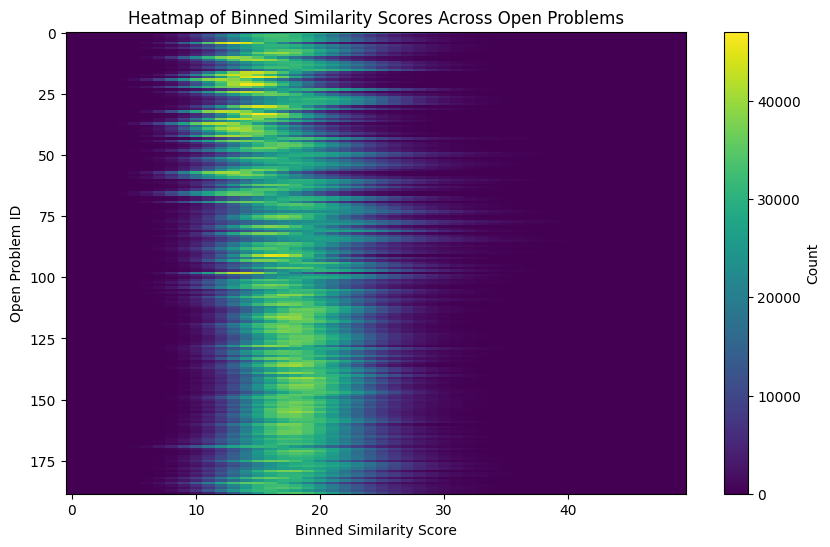

In [37]:
plot = distribution_heat_map(melted_df)
plot.savefig("figures/similarity_heatmap.png", format="png", dpi=300)

<Figure size 1400x800 with 0 Axes>

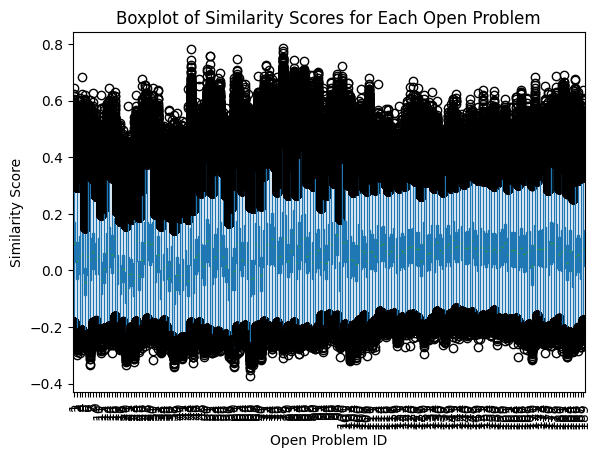

In [27]:
distribution_box_plot(melted_df)